In [1]:
import mysql.connector
import pandas as pd
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
%matplotlib inline
rc('font', family='Malgun Gothic')

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 10) 

## db 접속

In [2]:
dotenv_path = "../.env"
load_dotenv(dotenv_path)

db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name = os.getenv("DB_NAME")

In [3]:
conn = mysql.connector.connect(
    host = db_host,
    port = db_port,
    database = db_name,
    user = db_user,
    password = db_password
)

mycursor = conn.cursor()

In [4]:
mycursor.execute('show tables;')

for x in mycursor:
    print(x)

('customer',)
('discount',)
('marketing',)
('product',)
('sales',)
('tax',)


## 최근 거래일과 가입기간, 거래기간

In [5]:
sql = '''
SELECT s.CustomerID, 
       c.SubscriptionPeriod,
       MIN(s.TransactionDate) AS 최초거래일, 
       MAX(s.TransactionDate) AS 최근거래일
FROM sales s
JOIN customer c ON s.CustomerID = c.CustomerID
GROUP BY s.CustomerID, c.SubscriptionPeriod;
'''
def show_sql_result(sql):
       mycursor.execute(sql)
       rows = mycursor.fetchall()
       columns = [column[0] for column in mycursor.description]
       table_data = pd.DataFrame(rows, columns=columns)
       return table_data

show_sql_result(sql)

,CustomerID,SubscriptionPeriod,최초거래일,최근거래일
0,USER_0000,31,2019-09-15,2019-09-15
1,USER_0001,20,2019-03-24,2019-11-02
2,USER_0002,39,2019-06-22,2019-10-19
3,USER_0003,25,2019-12-14,2019-12-14
4,USER_0004,31,2019-09-15,2019-09-15
...,...,...,...,...
1463,USER_1463,5,2019-04-05,2019-04-05
1464,USER_1464,43,2019-06-22,2019-10-05
1465,USER_1465,25,2019-04-05,2019-06-20
1466,USER_1466,47,2019-10-23,2019-10-23


In [6]:
sql = '''
SELECT s.CustomerID, 
       c.SubscriptionPeriod,
       MIN(s.TransactionDate) AS 최초거래일, 
       MAX(s.TransactionDate) AS 최근거래일,
       TIMESTAMPDIFF(MONTH, MIN(s.TransactionDate), MAX(s.TransactionDate)) + 1 AS 거래기간
FROM sales s
JOIN customer c ON s.CustomerID = c.CustomerID
GROUP BY s.CustomerID
HAVING 거래기간 > c.SubscriptionPeriod;
'''
show_sql_result(sql)

,CustomerID,SubscriptionPeriod,최초거래일,최근거래일,거래기간
0,USER_0034,2,2019-01-11,2019-10-30,10
1,USER_0147,8,2019-01-09,2019-11-12,11
2,USER_0200,5,2019-02-09,2019-08-31,7
3,USER_0203,4,2019-01-16,2019-09-30,9
4,USER_0270,2,2019-03-27,2019-07-08,4
...,...,...,...,...,...
34,USER_1379,7,2019-04-25,2019-12-13,8
35,USER_1391,10,2019-01-31,2019-12-13,11
36,USER_1393,7,2019-03-02,2019-11-19,9
37,USER_1397,6,2019-03-29,2019-12-12,9


- 거래기간보다 가입기간이 짧은 고객 : 39명(2.7%)
    - 단순 오류?
- 가입 기간 산정 방식
    - 19년 12월 기준 : 잘 안 맞는 데이터가 많음
    - 최근 거래일 기준 : 최초 가입일로부터 최근 거래일까지의 기간
    - 별도 서비스 가입 : 홍보 메일 수신, 유료 구독 서비스 등 별도 서비스 가입 기간을 계산

## 매출, ARPU

In [7]:
sql = '''
Select CustomerID, TransactionID, ProductID, ProductCategory, Quantity, AverageAmount, CouponStatus, (Quantity * AverageAmount) as 매출 
From sales
GROUP BY CustomerID, TransactionID
;
'''
show_sql_result(sql)

,CustomerID,TransactionID,ProductID,ProductCategory,Quantity,AverageAmount,CouponStatus,매출
0,USER_0000,Transaction_16900,Product_0048,Apparel,1,19.99,Used,19.99
1,USER_0001,Transaction_20178,Product_0905,Office,1,2.39,Used,2.39
2,USER_0001,Transaction_20179,Product_0195,Lifestyle,3,3.19,Clicked,9.57
3,USER_0001,Transaction_20180,Product_0989,Nest-USA,1,149.00,Not Used,149.00
4,USER_0001,Transaction_20181,Product_0989,Nest-USA,1,149.00,Clicked,149.00
...,...,...,...,...,...,...,...,...
26626,USER_1467,Transaction_18634,Product_0992,Nest,1,99.00,Clicked,99.00
26627,USER_1467,Transaction_18635,Product_0880,Drinkware,4,2.99,Not Used,11.96
26628,USER_1467,Transaction_18636,Product_0837,Apparel,1,15.19,Used,15.19
26629,USER_1467,Transaction_18637,Product_0095,Apparel,1,15.00,Used,15.00


- 동일 상품, 같은 쿠폰 적용에도 평균 금액이 다른 이유
    - 상품 옵션에 따라(ex. 크기, 부가옵션 등)

In [8]:
sql = '''
SELECT 
    SUM(매출) AS 총매출, 
    COUNT(DISTINCT CustomerID) AS 총고객수, 
    ROUND(SUM(매출) / COUNT(DISTINCT CustomerID), 2) AS ARPU
FROM (
    SELECT 
        CustomerID, 
        TransactionID, 
        SUM(Quantity * AverageAmount) AS 매출
    FROM sales
    GROUP BY CustomerID, TransactionID
) AS 매출_합계
;
'''
show_sql_result(sql)

,총매출,총고객수,ARPU
0,4670794.62,1468,3181.74


In [9]:
sql = '''
SELECT 
    count(DISTINCT CustomerID) AS 총고객수
FROM
    customer
;
'''
show_sql_result(sql)

,총고객수
0,1468


- 고객 명부 상 모든 고객이 구매를 했으므로 ARPU = ARPPU

In [33]:
sql = '''
SELECT 
    DATE_FORMAT(TransactionDate, '%Y-%m') AS 월, 
    COUNT(DISTINCT CustomerID) AS 월별_구매고객,
    ROUND(SUM(매출), 2) AS 월별_매출,
    ROUND(SUM(매출) / COUNT(DISTINCT CustomerID), 2) AS 월별_ARPU
FROM(
    SELECT 
        CustomerID,
        TransactionDate,
        SUM(Quantity * AverageAmount) AS 매출
    FROM
        sales
    GROUP BY
        CustomerID, TransactionDate
) AS 매출_합계
GROUP BY 월
ORDER BY 월
;
'''
month_arpu = show_sql_result(sql)
month_arpu

,월,월별_구매고객,월별_매출,월별_ARPU
0,2019-01,215,403624.58,1877.32
1,2019-02,109,310819.80,2851.56
2,2019-03,208,349608.09,1680.81
3,2019-04,224,401618.42,1792.94
4,2019-05,200,307763.42,1538.82
5,2019-06,259,321081.38,1239.70
6,2019-07,236,372638.07,1578.97
7,2019-08,300,401210.37,1337.37
8,2019-09,193,360548.40,1868.13
9,2019-10,210,409681.28,1950.86


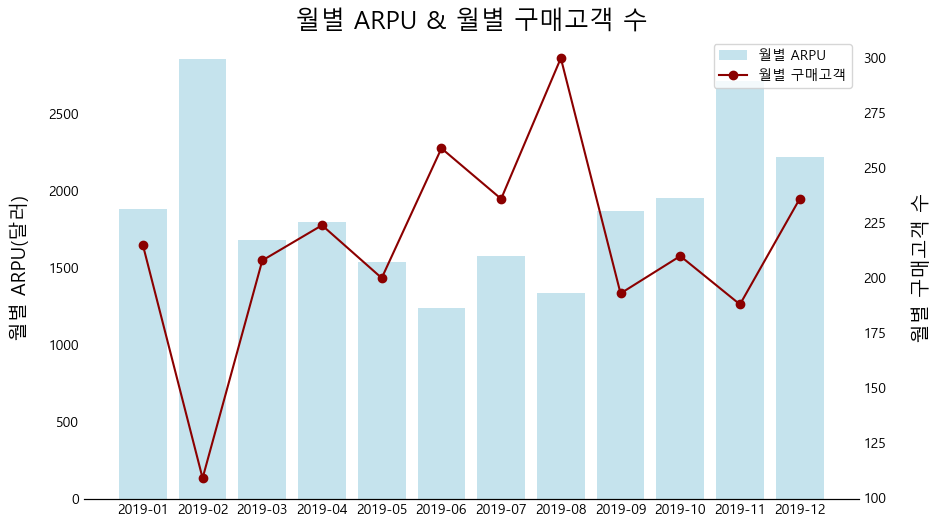

In [38]:
plt.figure(figsize=(10, 6))

ax1 = plt.gca()
ax1.bar(month_arpu.월, month_arpu.월별_ARPU, color='lightblue', alpha=0.7, label='월별 ARPU')
ax1.set_ylabel('월별 ARPU(달러)', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(month_arpu.월, month_arpu.월별_구매고객, color='darkred', marker='o', label='월별 구매고객')
ax2.set_ylabel('월별 구매고객 수', fontsize=14)

ax1.yaxis.set_tick_params(size=0)
ax2.yaxis.set_tick_params(size=0)
ax1.xaxis.set_tick_params(size=0)

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

ax1.yaxis.set_label_coords(-0.07, 0.5)
ax2.yaxis.set_label_coords(1.07, 0.5)

plt.title('월별 ARPU & 월별 구매고객 수', fontsize=18)
plt.show()

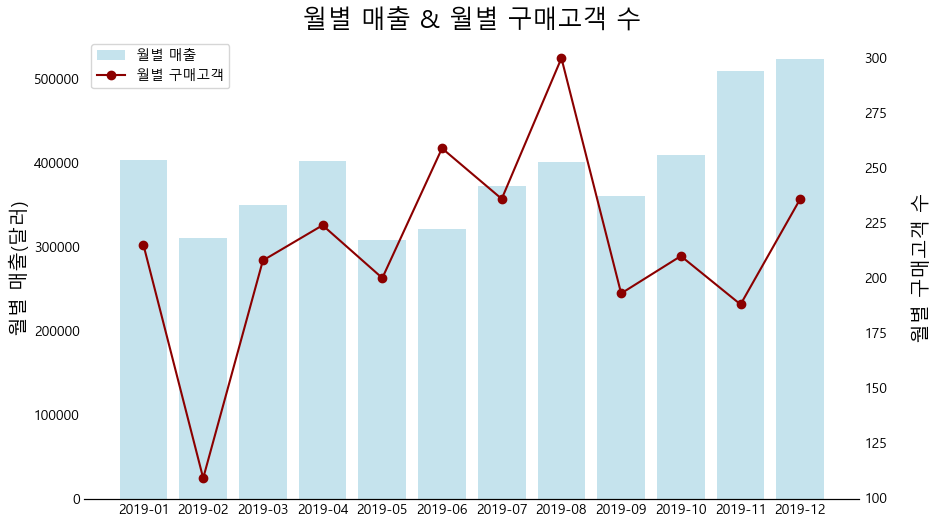

In [39]:
plt.figure(figsize=(10, 6))

ax1 = plt.gca()
ax1.bar(month_arpu.월, month_arpu.월별_매출, color='lightblue', alpha=0.7, label='월별 매출')
ax1.set_ylabel('월별 매출(달러)', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(month_arpu.월, month_arpu.월별_구매고객, color='darkred', marker='o', label='월별 구매고객')
ax2.set_ylabel('월별 구매고객 수', fontsize=14)

ax1.yaxis.set_tick_params(size=0)
ax2.yaxis.set_tick_params(size=0)
ax1.xaxis.set_tick_params(size=0)

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

ax1.yaxis.set_label_coords(-0.07, 0.5)
ax2.yaxis.set_label_coords(1.07, 0.5)

plt.title('월별 매출 & 월별 구매고객 수', fontsize=18)
plt.show()

## 매출 변화 원인 파악

- 매출 증가 3가지 시나리오
    - ARPU 증가 & 구매고객 수 유지
    - ARPU 유지 & 구매고객 수 증가
    - ARPU 증가 & 구매고객 수 증가
- 매출 감소도 동일하게 생각할 수 있음

In [56]:
import numpy as np

# 매출 증가/감소 분석
month_arpu['매출_변화'] = month_arpu['월별_매출'].diff()
month_arpu['구매고객_변화'] = month_arpu['월별_구매고객'].diff()
month_arpu['ARPU_변화'] = month_arpu['월별_ARPU'].diff()

# 증가 사유 분류
conditions = [
    (month_arpu['매출_증가'] > 0) & (month_arpu['구매고객_증가'] <= 0) & (month_arpu['ARPU_증가'] > 0), # ARPU 증가
    (month_arpu['매출_증가'] > 0) & (month_arpu['구매고객_증가'] > 0) & (month_arpu['ARPU_증가'] <= 0), # 구매고객 증가
    (month_arpu['매출_증가'] > 0) & (month_arpu['구매고객_증가'] > 0) & (month_arpu['ARPU_증가'] > 0),  # 둘 다 증가
    (month_arpu['매출_증가'] < 0) & (month_arpu['구매고객_증가'] >= 0) & (month_arpu['ARPU_증가'] < 0), # ARPU 감소
    (month_arpu['매출_증가'] < 0) & (month_arpu['구매고객_증가'] < 0) & (month_arpu['ARPU_증가'] >= 0), # 구매고객 감소
    (month_arpu['매출_증가'] < 0) & (month_arpu['구매고객_증가'] < 0) & (month_arpu['ARPU_증가'] < 0)  # 둘 다 감소
]

choices = ['ARPU 증가', '구매고객 증가', '구매고객 및 ARPU 증가', 'ARPU 감소', '구매고객 감소', '구매고객 및 ARPU 감소']

month_arpu['변화_사유'] = np.select(conditions, choices, default='감소 혹은 변화 없음')
month_arpu[['월', '매출_변화', '구매고객_변화', 'ARPU_변화', '변화_사유']]

,월,매출_변화,구매고객_변화,ARPU_변화,변화_사유
0,2019-01,NaN,NaN,NaN,감소 혹은 변화 없음
1,2019-02,-92804.78,-106.0,974.24,구매고객 감소
2,2019-03,38788.29,99.0,-1170.75,구매고객 증가
3,2019-04,52010.33,16.0,112.13,구매고객 및 ARPU 증가
4,2019-05,-93855.00,-24.0,-254.12,구매고객 및 ARPU 감소
5,2019-06,13317.96,59.0,-299.12,구매고객 증가
6,2019-07,51556.69,-23.0,339.27,ARPU 증가
7,2019-08,28572.30,64.0,-241.60,구매고객 증가
8,2019-09,-40661.97,-107.0,530.76,구매고객 감소
9,2019-10,49132.88,17.0,82.73,구매고객 및 ARPU 증가


1. 구매 고객 수의 변화가 매출에 중요한 영향
2. ARPU 변화도 매출에 영향을 미치지만 구매고객 변화만큼 직접적이지 않음
3. 구매고객과 ARPU가 동시에 증가하거나 감소할 때 매출 변화가 더 명확함

> 고객 유치 및 유지 전략 필요
- ARPU가 매출 증가에 더 중요한 요소라면 고객 가치를 높이기 위해 프리미엄 제품 제공이나 고가 전략을 구사할 수 있음
- 하지만, 본 데이터에선 구매고객 수가 매출에 더 중요한 요소인만큼 고객수를 늘리기 위한 마케팅이 중요

## 제품별, 카테고리별 판매

In [66]:
sql = '''
WITH MonthlySale AS (
    SELECT
        DATE_FORMAT(TransactionDate, '%Y-%m') AS 월,
        ProductID,
        ProductCategory,
        COUNT(*) AS 전체판매수
    FROM
        sales
    GROUP BY
        월, ProductID, ProductCategory
),
TotalMonthlySale AS (
    SELECT
        월,
        SUM(전체판매수) OVER(PARTITION BY 월) AS 월별전체판매수
    FROM
        MonthlySale
),
RankedSale AS (
    SELECT
        MonthlySale.월,
        ProductID,
        ProductCategory,
        전체판매수,
        월별전체판매수,
        ROW_NUMBER() OVER (PARTITION BY MonthlySale.월 ORDER BY 전체판매수 DESC) AS 판매순위
    FROM
        MonthlySale
    JOIN
        TotalMonthlySale ON MonthlySale.월 = TotalMonthlySale.월
)
SELECT 
    월,
    ProductID AS 최다판매제품,
    ProductCategory AS 최대판매제품분류,
    전체판매수 AS 최대판매제품_판매수,
    월별전체판매수
FROM
    RankedSale
WHERE
    판매순위=1
ORDER BY
    월
;
'''
mothly_product = show_sql_result(sql)
mothly_product

,월,최다판매제품,최대판매제품분류,최대판매제품_판매수,월별전체판매수
0,2019-01,Product_0981,Nest-USA,586,4063
1,2019-02,Product_0981,Nest-USA,344,3284
2,2019-03,Product_0983,Nest-USA,316,4346
3,2019-04,Product_0976,Nest-USA,244,4150
4,2019-05,Product_0976,Nest-USA,251,4572
5,2019-06,Product_0983,Nest-USA,294,4193
6,2019-07,Product_0983,Nest-USA,289,5251
7,2019-08,Product_0983,Nest-USA,276,6150
8,2019-09,Product_0976,Nest-USA,212,4288
9,2019-10,Product_0983,Nest-USA,271,4164


In [70]:
mothly_product.groupby('최다판매제품', as_index=False).sum(['최대판매제품_판매수', '월별전체판매수']).rename(columns=
                                                                                       {'최다판매제품': '제품ID', '최다제품_판매수':'19년 판매수'})

,제품ID,최대판매제품_판매수
0,Product_0976,707
1,Product_0981,1649
2,Product_0983,1446


- 가장 많이 판매되는 제품 카테고리는 Nest-USA(구글 스마트홈 제품 브랜드)
    - Product_0981 > Product_0983 > Product_0976

In [7]:
show_sql_result('select * from sales')

,CustomerID,TransactionID,TransactionDate,ProductID,ProductCategory,Quantity,AverageAmount,ShippingFee,CouponStatus
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.50,Not Used
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.50,Used
...,...,...,...,...,...,...,...,...,...
52919,USER_1144,Transaction_9999,2019-06-07,Product_0224,Apparel,1,15.99,6.00,Clicked
52920,USER_1144,Transaction_9999,2019-06-07,Product_0337,Apparel,1,59.99,6.00,Clicked
52921,USER_1144,Transaction_9999,2019-06-07,Product_0418,Apparel,1,15.19,6.00,Used
52922,USER_1144,Transaction_9999,2019-06-07,Product_0634,Apparel,1,67.19,6.00,Used


In [25]:
sql = '''
SELECT
    ProductCategory,
    COUNT(*) AS 판매개수,
    ROUND(AVG(AverageAmount), 2) AS 평균가격,
    SUM(Quantity * AverageAmount) AS 매출액
FROM
    sales
GROUP BY
    ProductCategory
;
'''
cat_sum = show_sql_result(sql)
cat_sum

,ProductCategory,판매개수,평균가격,매출액
0,Accessories,234,8.21,7295.88
1,Android,43,15.90,711.03
2,Apparel,18126,19.79,591145.80
3,Backpacks,89,80.05,8772.69
4,Bags,1882,29.83,151314.43
5,Bottles,268,3.44,6923.65
6,Drinkware,3483,10.70,200707.83
7,Fun,160,6.74,6029.01
8,Gift Cards,159,111.36,19533.82
9,Google,105,16.45,9420.47


In [26]:
cat_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ProductCategory  20 non-null     object
 1   판매개수             20 non-null     int64 
 2   평균가격             20 non-null     object
 3   매출액              20 non-null     object
dtypes: int64(1), object(3)
memory usage: 768.0+ bytes


In [27]:
cat_sum['매출액'] = cat_sum['매출액'].astype(float)

In [28]:
total_sales = cat_sum['매출액'].sum()
total_quantity = cat_sum['판매개수'].sum()
cat_sum['매출액_비중'] = round((cat_sum['매출액'] / total_sales) * 100, 2)
cat_sum['판매개수_비중'] = round((cat_sum['판매개수'] / total_quantity) * 100, 2)

cat_sum[['ProductCategory', '판매개수_비중', '매출액_비중']]

,ProductCategory,판매개수_비중,매출액_비중
0,Accessories,0.44,0.16
1,Android,0.08,0.02
2,Apparel,34.25,12.66
3,Backpacks,0.17,0.19
4,Bags,3.56,3.24
5,Bottles,0.51,0.15
6,Drinkware,6.58,4.30
7,Fun,0.30,0.13
8,Gift Cards,0.30,0.42
9,Google,0.20,0.20


- 가장 많이 판매된 제품카테고리는 Apparel(전체 판매 개수의 34.25%, 전체 매출액의 12.66%)
- 매출이 가장 많은 카테고리는 Nest-USA(전체 판매 개수의 26.48%, 전체 매출액의 54.68%)
    - Nest 관련 카테고리가 전체 판매량의 30%, 전체 매출액의 65%
    - Nest 관련 상품은 100불 이상으로 상대적 고가치 상품 & 판매량도 상위권 => 전체 매출의 절반 이상

In [32]:
sql = '''
SELECT
    DATE_FORMAT(TransactionDate, '%Y-%m') AS 월,
    ProductCategory,
    COUNT(*) AS 판매수,
    SUM(Quantity * AverageAmount) AS 매출액
FROM
    sales
WHERE
    ProductCategory IN ('Nest', 'Nest-USA', 'Nest-Canada', 'Office', 'Apparel')
GROUP BY
    월, ProductCategory
ORDER BY
    월, ProductCategory
;
'''
major_sales = show_sql_result(sql)
major_sales

,월,ProductCategory,판매수,매출액
0,2019-01,Apparel,960,38300.87
1,2019-01,Nest-Canada,39,9591.11
2,2019-01,Nest-USA,1563,284362.08
3,2019-01,Office,607,27309.50
4,2019-02,Apparel,905,37990.09
...,...,...,...,...
48,2019-12,Apparel,1337,48236.94
49,2019-12,Nest,712,145354.52
50,2019-12,Nest-Canada,26,5291.29
51,2019-12,Nest-USA,1534,280190.12


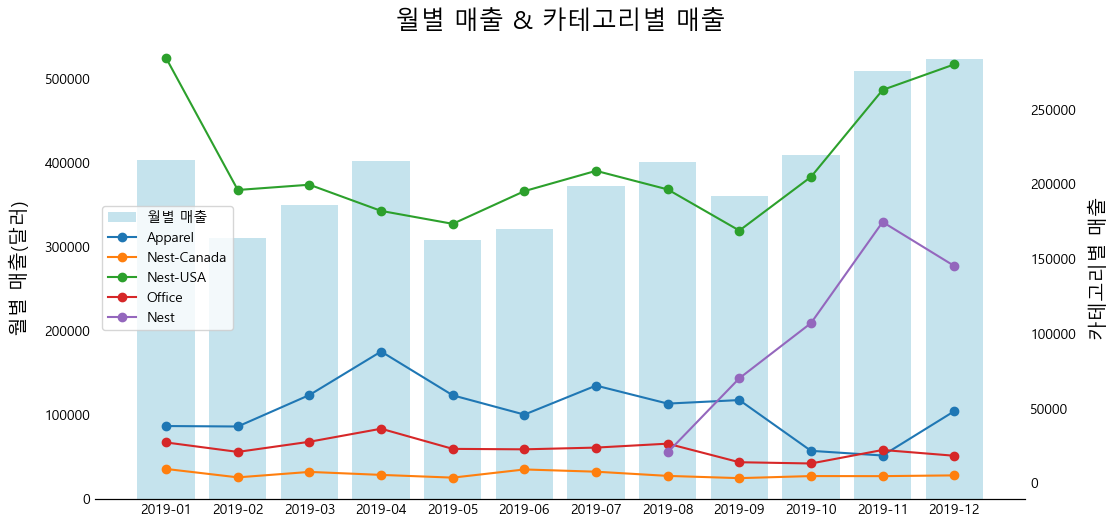

In [44]:
plt.figure(figsize=(12, 6))

ax1 = plt.gca()
ax1.bar(month_arpu.월, month_arpu.월별_매출, color='lightblue', alpha=0.7, label='월별 매출')
ax1.set_ylabel('월별 매출(달러)', fontsize=14)

ax2 = ax1.twinx()
categories = major_sales['ProductCategory'].unique()
for cat in categories:
    filtered_data = major_sales[major_sales['ProductCategory']==cat]
    ax2.plot(filtered_data.월, filtered_data.매출액, marker='o', label=cat)
ax2.set_ylabel('카테고리별 매출', fontsize=14)

ax1.yaxis.set_tick_params(size=0)
ax2.yaxis.set_tick_params(size=0)
ax1.xaxis.set_tick_params(size=0)

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

ax1.yaxis.set_label_coords(-0.07, 0.5)
ax2.yaxis.set_label_coords(1.07, 0.5)

plt.title('월별 매출 & 카테고리별 매출', fontsize=18)
plt.show()

- 2~4월의 매출 상승은 Apparel 상품 매출 증가 영향
- 9~12월 매출 상승은 대체로 Nest-USA, Nest 매출 증가가 견인
- Nest는 8월부터 매출이 발생했으나 전체 매출액 비중이 11%
    - 20년에는 19년 대비 매출 상승 기대

In [45]:
mycursor.close()
conn.close()